In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import easysnowdata as esd
import coincident
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import xdem
from shapely.geometry import box
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('/home/jehayes/gda_final/ATL06_LaserLottery/misc'))
from nlcd_plot import nlcd_labels, nlcd_colors
import sr_wrapper
import stac_helper
%load_ext autoreload
%autoreload 2

/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


Identify a USGS 3DEP site of interest

In [2]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")
aoi = gf_flights.iloc[[0]]
gf_wesm = coincident.search.wesm.load_by_fid(fids=aoi.fid.values)

Get ICESat-2 tracks within +-12 days of 3DEP collection

In [3]:
atl06_items = stac_helper.get_atl06_stac(aoi.iloc[0], window_days=12)
gf_atl06_stac = stac_helper.to_geopandas(atl06_items[0].item_collection())

In [4]:
gf_atl06_stac

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,datetime,end_datetime,start_datetime,dayofyear
0,{'24/ATL06_20210624003626_00061202_006_01': {'...,"{'xmin': -125.61423, 'ymin': 35.82996, 'xmax':...",ATL06_006,"POLYGON ((-125.39382 59.54551, -125.61423 59.5...",SC:ATL06.006:272416853,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-24 00:38:44.185000+00:00,2021-06-24 00:44:55.763000+00:00,2021-06-24 00:38:44.185000+00:00,175
1,{'26/ATL06_20210626124356_00441206_006_01': {'...,"{'xmin': -123.56884, 'ymin': 38.12829, 'xmax':...",ATL06_006,"POLYGON ((-120.15698 59.53431, -120.37752 59.5...",SC:ATL06.006:272422736,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-26 12:43:55.642000+00:00,2021-06-26 12:49:31.271000+00:00,2021-06-26 12:43:55.642000+00:00,177


In [5]:
gf_atl06_points = sr_wrapper.get_atl06(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= aoi.iloc[0].geometry,
)

{'poly': [{'lon': -123.06609344482422, 'lat': 44.00281524658203}, {'lon': -121.98262023925781, 'lat': 44.00281524658203}, {'lon': -121.98262023925781, 'lat': 44.35806655883789}, {'lon': -123.06609344482422, 'lat': 44.35806655883789}, {'lon': -123.06609344482422, 'lat': 44.00281524658203}], 't0': '2021-06-23T00:00:00Z', 't1': '2021-07-17T00:00:00Z', 'srt': 0, 'cnf': 4, 'ats': 10.0, 'cnt': 10, 'len': 40.0, 'res': 20.0, 'geoid': True, 'vars': ['h_mean', 'latitude', 'longitude', 'h_sigma', 'quality_summary'], 'samples': {}}


In [6]:
gf_wesm = gf_wesm.to_crs(gf_atl06_points.crs)
gf_atl06_points = gf_atl06_points.clip(gf_wesm.geometry)
print("CRS: {}".format(gf_atl06_points.crs))
print("Reference Ground Tracks: {}".format(gf_atl06_points["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_points["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_points.shape[0]))

CRS: EPSG:7912
Reference Ground Tracks: [44  6]
Cycles: [12]
Received 4677 elevations


In [7]:
#!gdalinfo /mnt/c/Users/JackE/uw/courses/wint25/gda/final_data/dem_10x.tif

In [8]:
#from osgeo import gdal
#import os
#
#infile = "/mnt/c/Users/JackE/uw/courses/wint25/gda/final_data/dem_10x.tif"
#src_crs = "EPSG:6557+8228"  # Source: NAD83(2011) / Oregon GIC Lambert (ft) + NAVD88 height (ft)
#target_crs = "EPSG:32610+4979"  # Target: WGS 84 / UTM zone 10N + WGS84 3D
#
#base, ext = os.path.splitext(infile)
#outfile = f"{base}_itrf{ext}"
#
#print(f"Reprojecting:\n  {infile}\n  (src SRS: {src_crs})\n-> {outfile}\n  (target SRS: {target_crs})\n")
#
#ds_out = gdal.Warp(outfile, infile, srcSRS=src_crs, dstSRS=target_crs, format="GTiff")
#
#if ds_out is None:
#    print(f"Error processing {infile}")
#else:
#    ds_out = None

In [12]:
ds_dem = xr.open_dataset("/mnt/c/Users/JackE/uw/courses/wint25/gda/final_data/dem_10x_itrf.tif", 
                         engine="rasterio").squeeze().rename({'band_data': 'elevation'}).rio.write_crs(32610)

In [13]:
ds_dem["hillshade"] = coincident.plot.hillshade(ds_dem.elevation)

/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/coincident/plot/utils.py:102: RuntimeWarning: invalid value encountered in cast
  return da.dims, data.astype(np.uint8)


In [14]:
dims = ds_dem.elevation.dims
ds_dem['slope'] = xr.DataArray(
    xdem.terrain.slope(ds_dem.elevation, resolution=(25, 25)),
    dims=dims
)
ds_dem['aspect'] = xr.DataArray(
    xdem.terrain.aspect(ds_dem.elevation),
    dims=dims
)

In [15]:
ds_dem.rio.crs

CRS.from_epsg(32610)

images/usgs_dem.png

In [ ]:
f, axs = plt.subplots(3,1,figsize=(12,18),
                      layout='constrained')

# elev
ax=axs[0]
ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)
ds_dem.elevation.plot.imshow(ax=ax,
                            cmap="inferno",
                            alpha=0.5,
                            cbar_kwargs={'label':'Elevation (m)'})
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)
ax.set_title("Elevation", fontsize=18)

# slope
ax=axs[1]
ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)
ds_dem.slope.plot.imshow(ax=ax,
                     cmap="viridis",
                     alpha=0.5,
                     vmax=45,
                     cbar_kwargs={'label':'Slope (degrees)'})
ax.set_title("Slope", fontsize=18)

# aspect
ax=axs[2]
ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)
ds_dem.aspect.plot.imshow(ax=ax,
                            cmap="twilight",
                            alpha=0.5,
                            cbar_kwargs={'label':'Aspect (degrees)'})
ax.set_title("Aspect", fontsize=18)

for ax in axs:
       ax.set_aspect('equal')
       ax.set(xticks=[], yticks=[], 
              xlabel="", ylabel="", 
              frame_on=False)
       
plt.suptitle("USGS 3DEP DEM (resampled to 10m)", fontsize=22);

In [16]:
elev_data = ds_dem.elevation.values.flatten()
slope_data = ds_dem.slope.values.flatten()
aspect_data = ds_dem.aspect.values.flatten()

images/usgs_hist.png

In [ ]:
f, axs = plt.subplots(3,1,figsize=(8,24), layout='constrained')

# Get middle colors from colormaps
inferno_mid = plt.cm.inferno(0.5)
viridis_mid = plt.cm.viridis(0.5)
twilight_mid = plt.cm.twilight(0.5)

# Elevation histogram
ax = axs[0]
ax.hist(elev_data, bins=256, color=inferno_mid, alpha=0.7)
ax.axvline(np.nanmean(elev_data), color='black', linestyle='--', 
           label=f'Mean: {np.nanmean(elev_data):.1f} m')
ax.axvline(np.nanmedian(elev_data), color='black', linestyle=':', 
           label=f'Med: {np.nanmedian(elev_data):.1f} m')
ax.set_title("Elevation", fontsize=20)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Count")
ax.legend(fontsize=18)

# Slope histogram
ax = axs[1]
ax.hist(slope_data, bins=256, color=viridis_mid, alpha=0.7)
ax.axvline(np.nanmean(slope_data), color='black', linestyle='--',
           label=f'Mean: {np.nanmean(slope_data):.1f}°')
ax.axvline(np.nanmedian(slope_data), color='black', linestyle=':',
           label=f'Med: {np.nanmedian(slope_data):.1f}°')
ax.set_title("Slope", fontsize=20)
ax.set_xlabel("Slope (degrees)")
ax.set_ylabel("Count")
ax.legend(fontsize=18)

# Aspect histogram
ax = axs[2]
ax.hist(aspect_data, bins=256, color=twilight_mid, alpha=0.7)
ax.axvline(np.nanmean(aspect_data), color='black', linestyle='--',
           label=f'Mean: {np.nanmean(aspect_data):.1f}°')
ax.axvline(np.nanmedian(aspect_data), color='black', linestyle=':',
           label=f'Med: {np.nanmedian(aspect_data):.1f}°')
ax.set_title("Aspect", fontsize=20)
ax.set_xlabel("Aspect (degrees)")
ax.set_ylabel("Count")
ax.legend(fontsize=18);

images/atl06_default_hillshade.png

In [17]:
gf_atl06_points_utm = gf_atl06_points.to_crs(32610)

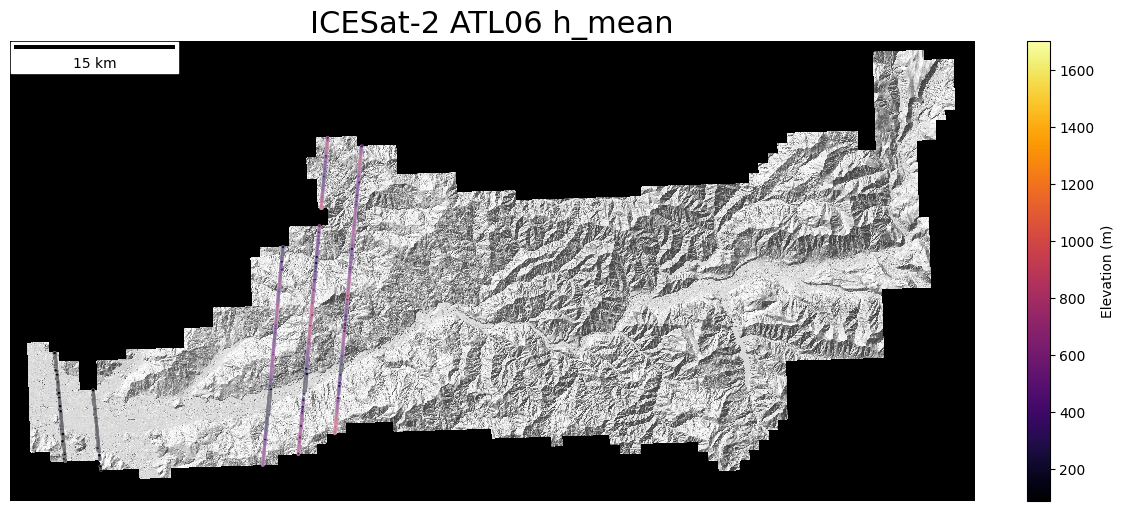

In [18]:
f, ax = plt.subplots(figsize=(12,5),
                      layout='constrained')

ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)
gf_atl06_points_utm.plot(ax=ax, cmap='inferno',
                         alpha=0.5,
                         legend=True,
                         column="h_mean",
                         legend_kwds={'label': "Elevation (m)"},
                         markersize=5,
                         edgecolor='white',
                         linewidth=0.2,
                         vmin=np.nanmin(ds_dem.elevation),
                         vmax=np.nanmax(ds_dem.elevation))
scalebar = ScaleBar(1, location='upper left')
ax.add_artist(scalebar)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)   
ax.set_title("ICESat-2 ATL06 h_mean", fontsize=22);

images/atl06_default_hillshade_zoom.png

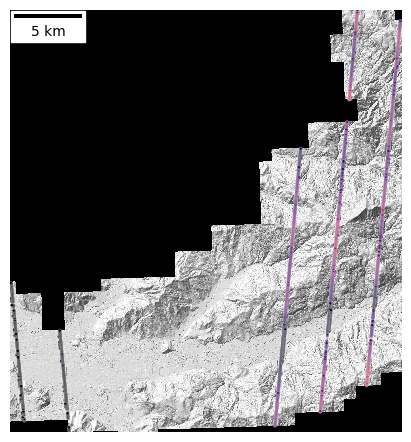

In [ ]:
f, ax = plt.subplots(figsize=(4,5), layout='constrained')

bounds = gf_atl06_points_utm.total_bounds

ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)

gf_atl06_points_utm.plot(ax=ax, cmap='inferno',
                         alpha=0.5,
                         legend=False,
                         column="h_mean",
                         markersize=5,
                         edgecolor='white',
                         linewidth=0.2,
                         vmin=np.nanmin(ds_dem.elevation),
                         vmax=np.nanmax(ds_dem.elevation))

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

scalebar = ScaleBar(1, location='upper left')
ax.add_artist(scalebar)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[],
       xlabel="", ylabel="",
       frame_on=False,
       title="");

sample my dample

In [26]:
# Function to create a 40m x 40m square centered on a point (buffer of 20m)
def create_square(pt, half_side=20):
    return box(pt.x - half_side, pt.y - half_side, pt.x + half_side, pt.y + half_side)

# Assuming gf_atl06_points_utm is your GeoDataFrame with point geometries and a column 'h_mean'
# Create a new column 'bbox' with the square geometries
gf_atl06_points_utm['bbox'] = gf_atl06_points_utm.geometry.apply(create_square)

# List to hold average DEM elevation values for each bounding box
dem_elev_avg = []

# Loop over each bounding box in the geodataframe
for geom in tqdm(gf_atl06_points_utm['bbox']):
    # Get the bounds of the square: minx, miny, maxx, maxy
    minx, miny, maxx, maxy = geom.bounds
    
    # Subset the ds_dem elevation using a where condition.
    # Note: adjust coordinate names (e.g., 'x', 'y') as needed based on your dataset.
    da_subset = ds_dem.elevation.where(
        (ds_dem.x >= minx) & (ds_dem.x <= maxx) &
        (ds_dem.y >= miny) & (ds_dem.y <= maxy),
        drop=True
    )
    
    # Calculate the mean elevation in the subset (averaging over intersecting 10x10 m cells)
    avg_elev = da_subset.mean().item()
    dem_elev_avg.append(avg_elev)

# Save the DEM mean elevations into the geodataframe and compute the elevation difference
gf_atl06_points_utm['dem_elev'] = dem_elev_avg
gf_atl06_points_utm['elev_diff'] = gf_atl06_points_utm['h_mean'] - gf_atl06_points_utm['dem_elev']

100%|██████████| 2490/2490 [16:33<00:00,  2.51it/s]


In [20]:
gf_atl06_points_utm = gpd.read_parquet("/home/jehayes/gda_final/ATL06_LaserLottery/data/OR_McKenzieRiver_1_2021_gridsearch/nlcd_40.0_20.0_10_10.0.parquet")

In [22]:
gf_atl06_bbox = gpd.GeoDataFrame(
    geometry=[gf_atl06_points_utm.geometry.union_all().envelope], 
    crs=gf_atl06_points_utm.crs
).to_crs(4326)

In [23]:
import odc.stac
import pystac_client
import planetary_computer

In [24]:
aoi

,fid,minx,maxx,miny,maxy,workunit,workunit_id,project,project_id,start_datetime,...,lpc_link,sourcedem_link,metadata_link,collection,datetime,dayofyear,duration,tree_cover,granule_count_30d,geometry
0,2801,-123.066093,-121.98262,44.002815,44.358067,OR_McKenzieRiver_1_2021,220421,OR_McKenzieRiver_2021_B21,220424,2021-07-04,...,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,3DEP,2021-07-05,186,2,4185.5571,4,"POLYGON ((-121.98262 44.00282, -121.98262 44.3..."


In [25]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)
search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=gf_atl06_bbox.geometry.item(),
        datetime=f'2021-06-15/2021-07-15')
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 48 Items


In [26]:
gf_atl06_bbox

,geometry
0,"POLYGON ((-123.03459 44.01024, -122.67599 44.0..."


In [ ]:
# isolate the image with the lowest cloud cover percentage
# not sure if output_crs should just be 7912 or 4326->reproject
sentinel2_stac = odc.stac.load(items,chunks={"x": 2048, "y": 2048},
                               resolution=20, groupby='solar_day')
minx, miny, maxx, maxy = gf_atl06_bbox.geometry.iloc[0].bounds
sentinel2_stac_clipped = sentinel2_stac.rio.clip_box(minx, miny, maxx, maxy, 
                                                     crs="EPSG:4326")
scl = sentinel2_stac_clipped["SCL"]
cloud_classes = [8, 9, 10]
idx_least_clouds = scl.where(~scl.isin(cloud_classes)).sum(dim=['x','y']).idxmax()
sentinel2_best = sentinel2_stac_clipped.sel(time=idx_least_clouds)
cloud_coverage = [item.properties.get('eo:cloud_cover', 100) for item in items]
best_idx = np.argmin(cloud_coverage)
best_datetime = items[best_idx].datetime
print(f"Selected image datetime: {best_datetime}")

Selected image datetime: 2021-06-26 18:59:19.024000+00:00


/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [28]:
# stack the RGB bands
rgb = np.dstack([
    sentinel2_best.B04.compute(),
    sentinel2_best.B03.compute(),
    sentinel2_best.B02.compute()
])
rgb_norm = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))
# and brighten the image so it's easier to visually interpret
gamma = 0.5  
rgb_bright = np.power(rgb_norm, gamma)

In [29]:
# and turn into an xarray da with CRS information
da_rgb = xr.DataArray(
    np.moveaxis(rgb_bright, -1, 0),  # move band dimension to front
    dims=['band', 'y', 'x'],
    coords={
        'band': ['red', 'green', 'blue'],
        'y': sentinel2_best.y,
        'x': sentinel2_best.x
    }
).rio.write_crs(sentinel2_best.rio.crs)

In [32]:
nlcd_landcover = esd.remote_sensing.get_nlcd_landcover(gf_atl06_bbox.iloc[0].geometry.buffer(.15), layer='landcover')
da_nlcd = nlcd_landcover.rio.reproject(32610)

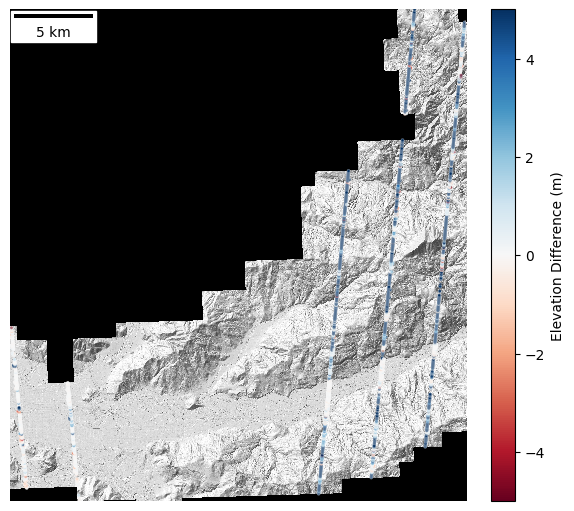

In [45]:
f, ax = plt.subplots(figsize=(6,5), layout='constrained')

bounds = gf_atl06_points_utm.total_bounds

ds_dem.hillshade.plot.imshow(ax=ax,
                            cmap="gray",
                            add_colorbar=False)

gf_atl06_points_utm.plot(ax=ax, cmap='RdBu',
                         alpha=0.5,
                         legend=True,
                         column="elev_diff",
                         markersize=5,
                         edgecolor='white',
                         linewidth=0.2,
                         vmin=-5,
                         vmax=5,
                         legend_kwds={'label': 'Elevation Difference (m)'})

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

scalebar = ScaleBar(1, location='upper left')
ax.add_artist(scalebar)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[],
       xlabel="", ylabel="",
       frame_on=False,
       title="");

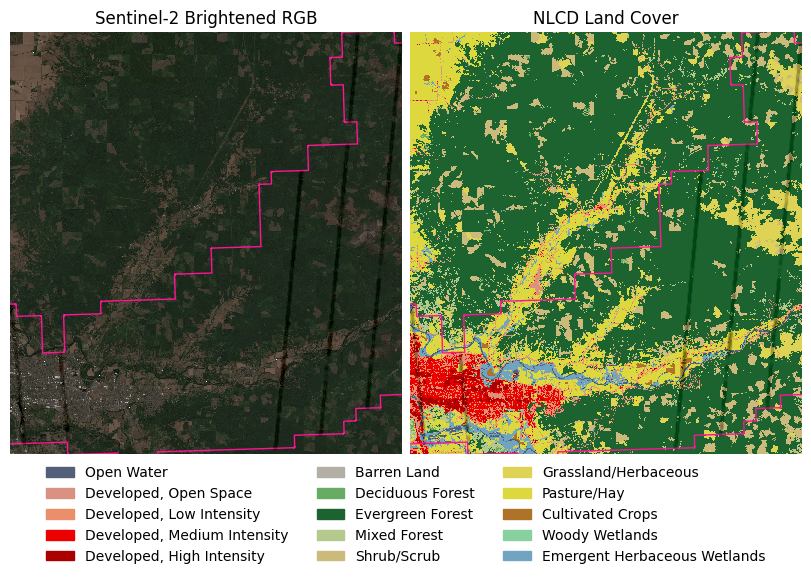

In [50]:
f, axs = plt.subplots(1,2, figsize=(8,7),
                      layout='constrained')

# Sentinel-2
ax=axs[0]
da_rgb.plot.imshow(ax=ax)
ax.set_title("Sentinel-2 Brightened RGB")

# NLCD landcover
ax = axs[1]

# Create a proper categorical colormap
present_classes = np.unique(da_nlcd.values[~np.isnan(da_nlcd.values)])
present_classes = present_classes[present_classes != 255]

# Create a colormap using only the present classes
cmap = mcolors.ListedColormap([nlcd_colors[int(i)] for i in present_classes])
norm = mcolors.BoundaryNorm(present_classes, len(present_classes))

# Plot with the norm parameter to ensure proper color mapping
da_nlcd.plot.imshow(ax=ax,
                    cmap=cmap,
                    norm=norm,
                    add_colorbar=False)

# Create legend for present classes
legend_handles = [
    mpatches.Patch(
        color=nlcd_colors[int(key)],
        label=nlcd_labels[int(key)]
    )
    for key in present_classes
]


f.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, 0.2),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=10
)
ax.set_title("NLCD Land Cover")

for ax in axs:
    gf_wesm.to_crs(32610).plot(ax=ax, facecolor='none', edgecolor='deeppink', linewidth=1)
    gf_atl06_points_utm.plot(ax=ax, color='k', markersize=5,
                            alpha=0.01)
    ax.set_aspect('equal')
    ax.set(xticks=[], yticks=[], 
            xlabel="", ylabel="", 
            frame_on=False)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3]);